In [542]:
# Necessary imports
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold
import numpy as np

from sklearn import tree
import matplotlib.pyplot as plt

In [543]:
def load_data():
    # Define the column names
    column_names = ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'class']

    # Load the data and add column names
    data = pd.read_csv('data/nursery.data', delimiter=',', names=column_names)

    return data

In [544]:
data = load_data()

# Print the shape of the data
print("Data Shape: ", data.shape)

# Print the first 10 rows
print(data.head(10).to_string(), "\n")

Data Shape:  (12960, 9)
  parents has_nurs      form children     housing     finance         social       health       class
0   usual   proper  complete        1  convenient  convenient        nonprob  recommended   recommend
1   usual   proper  complete        1  convenient  convenient        nonprob     priority    priority
2   usual   proper  complete        1  convenient  convenient        nonprob    not_recom   not_recom
3   usual   proper  complete        1  convenient  convenient  slightly_prob  recommended   recommend
4   usual   proper  complete        1  convenient  convenient  slightly_prob     priority    priority
5   usual   proper  complete        1  convenient  convenient  slightly_prob    not_recom   not_recom
6   usual   proper  complete        1  convenient  convenient    problematic  recommended    priority
7   usual   proper  complete        1  convenient  convenient    problematic     priority    priority
8   usual   proper  complete        1  convenient  conveni

In [545]:
# Get information about the data
print(data.describe().to_string(), "\n")

# Check if there are missing values
print(data.isnull().sum())

# Check the unique values in the class column
print(data['class'].value_counts())

       parents has_nurs      form children     housing     finance   social       health      class
count    12960    12960     12960    12960       12960       12960    12960        12960      12960
unique       3        5         4        4           3           2        3            3          5
top      usual   proper  complete        1  convenient  convenient  nonprob  recommended  not_recom
freq      4320     2592      3240     3240        4320        6480     4320         4320       4320 

parents     0
has_nurs    0
form        0
children    0
housing     0
finance     0
social      0
health      0
class       0
dtype: int64
class
not_recom     4320
priority      4266
spec_prior    4044
very_recom     328
recommend        2
Name: count, dtype: int64


In [546]:
def split_data(data, combine):
    # Separate the features and target variable before encoding
    X = data.drop('class', axis=1)
    y = data['class']

    # Combine 'recommend' and 'very_recom' into 'recommend_or_very_recom' because they have low counts
    if combine:
        y = y.replace({
            'recommend': 'recommend_or_very_recom',
            'very_recom': 'recommend_or_very_recom'
        })

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.25, random_state=13)

    return X_train, X_test, y_train, y_test, X, y

In [547]:
def training_with_DecisionTree(X_train, y_train, criteria):
    # Train the model with criteria
    model = DecisionTreeClassifier(criterion=criteria, random_state=13, max_depth=14)

    # Fit the model
    model.fit(X_train, y_train)

    return model

In [548]:
def training_with_XGBoost(X_train, y_train, estimators):
    # Train the model
    model = xgb.XGBClassifier(n_estimators=estimators, random_state=13)

    # Fit the model
    model.fit(X_train, y_train)

    return model

In [549]:
def predict(model, X_test):
    # Predict the target variable
    y_pred = model.predict(X_test)

    return y_pred

In [550]:
def evaluate(y_test, y_pred):
    # Evaluate the model
    confusion = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, zero_division=0)

    f1 = f1_score(y_test, y_pred, average='weighted')

    return confusion, classification_rep, f1

In [551]:
# Split the data
X_train, X_test, y_train, y_test, X, y = split_data(data, True)

# Get information about the data
print(X.describe().to_string(), "\n")
print(X.head(5).to_string(), "\n")
print(y.value_counts(), "\n")

       parents has_nurs      form children     housing     finance   social       health
count    12960    12960     12960    12960       12960       12960    12960        12960
unique       3        5         4        4           3           2        3            3
top      usual   proper  complete        1  convenient  convenient  nonprob  recommended
freq      4320     2592      3240     3240        4320        6480     4320         4320 

  parents has_nurs      form children     housing     finance         social       health
0   usual   proper  complete        1  convenient  convenient        nonprob  recommended
1   usual   proper  complete        1  convenient  convenient        nonprob     priority
2   usual   proper  complete        1  convenient  convenient        nonprob    not_recom
3   usual   proper  complete        1  convenient  convenient  slightly_prob  recommended
4   usual   proper  complete        1  convenient  convenient  slightly_prob     priority 

class
not_r

In [552]:
# Create LabelEncoder object
le = LabelEncoder()

# LabelEncoder on each column of X_train and X_test to convert categorical data to numeric
X_train_numeric = X_train.apply(le.fit_transform)
X_test_numeric = X_test.apply(le.fit_transform)

# Prints
print(X_train.head(3).to_string(), "\n")
print(X_train_numeric.head(3).to_string(), "\n")

          parents  has_nurs        form children     housing     finance         social       health
6932  pretentious  critical    complete        1   less_conv  convenient        nonprob    not_recom
555         usual    proper  incomplete        3  convenient      inconv    problematic  recommended
2451        usual  improper      foster        2   less_conv  convenient  slightly_prob  recommended 

      parents  has_nurs  form  children  housing  finance  social  health
6932        1         0     0         0        2        0       0       0
555         2         3     3         2        0        1       1       2
2451        2         1     2         1        2        0       2       2 



In [553]:
# For the Decision Tree model

def tune_random_forest(X_train, y_train):
    # Define the parameter values that should be searched
    param_grid = {'max_depth': list(range(1, 21))}

    # Define the cross-validation strategy and fix the random_state
    sKF = StratifiedKFold(n_splits=10, random_state=13, shuffle=True)

    # Instantiate the grid
    grid = GridSearchCV(DecisionTreeClassifier(random_state=13), param_grid, cv=sKF, scoring='f1_weighted')

    # Fit the grid with data
    grid.fit(X_train, y_train)

    best_params = grid.best_params_

    # View the optimal parameters
    print("Best parameters: ", best_params)

    return best_params

In [554]:
# Train the model with Decision Tree

# Tune the model
best_params = tune_random_forest(X_train_numeric, y_train)
print("Best parameters: ", best_params)

model_decision_tree = training_with_DecisionTree(X_train_numeric, y_train, 'gini')

# Prediction and evaluation
y_pred = predict(model_decision_tree, X_test_numeric)
confusion, classification, f1 = evaluate(y_test, y_pred)

# Prints
print("Confusion Matrix: \n", confusion, "\n")
print("Classification Report: \n", classification)
print("F1 Score: ", f1)

# Define the stratified k-fold cross-validation
stratifiedKF = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)

# Perform cross-validation
scores = cross_val_score(model_decision_tree, X_train_numeric, y_train, cv=stratifiedKF, scoring='f1_weighted')

# Print the cross-validation scores for each fold and average
print("\nCross-validation scores:", scores)
print("Average cross-validation score:", np.mean(scores))

Best parameters:  {'max_depth': 14}
Best parameters:  {'max_depth': 14}
Confusion Matrix: 
 [[1044    0    0    0]
 [   0 1081    1    5]
 [   0    3   88    0]
 [   0    3    0 1015]] 

Classification Report: 
                          precision    recall  f1-score   support

              not_recom       1.00      1.00      1.00      1044
               priority       0.99      0.99      0.99      1087
recommend_or_very_recom       0.99      0.97      0.98        91
             spec_prior       1.00      1.00      1.00      1018

               accuracy                           1.00      3240
              macro avg       0.99      0.99      0.99      3240
           weighted avg       1.00      1.00      1.00      3240

F1 Score:  0.996290649134214

Cross-validation scores: [0.99177054 0.98970326 0.98658837 0.9912818  0.99180506]
Average cross-validation score: 0.9902298076016244


In [555]:
# Train the model with XGBoost

# Transform y_train and y_test to numeric
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

model = training_with_XGBoost(X_train_numeric, y_train_encoded, 50)

# Prediction and evaluation
y_pred = predict(model, X_test_numeric)
confusion, classification, f1 = evaluate(y_test_encoded, y_pred)

# Prints
print("Confusion Matrix: \n", confusion, "\n")
print("Classification Report: \n", classification)
print("F1 Score: ", f1)

# Define the stratified k-fold cross-validation
stratifiedKF = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)

# Perform cross-validation
scores = cross_val_score(model, X_train_numeric, y_train_encoded, cv=stratifiedKF, scoring='f1_weighted')

# Print the cross-validation scores for each fold and average
print("\nCross-validation scores:", scores)
print("Average cross-validation score:", np.mean(scores))

Confusion Matrix: 
 [[1044    0    0    0]
 [   0 1087    0    0]
 [   0    0   91    0]
 [   0    0    0 1018]] 

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1044
           1       1.00      1.00      1.00      1087
           2       1.00      1.00      1.00        91
           3       1.00      1.00      1.00      1018

    accuracy                           1.00      3240
   macro avg       1.00      1.00      1.00      3240
weighted avg       1.00      1.00      1.00      3240

F1 Score:  1.0

Cross-validation scores: [0.99948561 0.99948309 0.99948561 1.         0.99948309]
Average cross-validation score: 0.9995874791060876


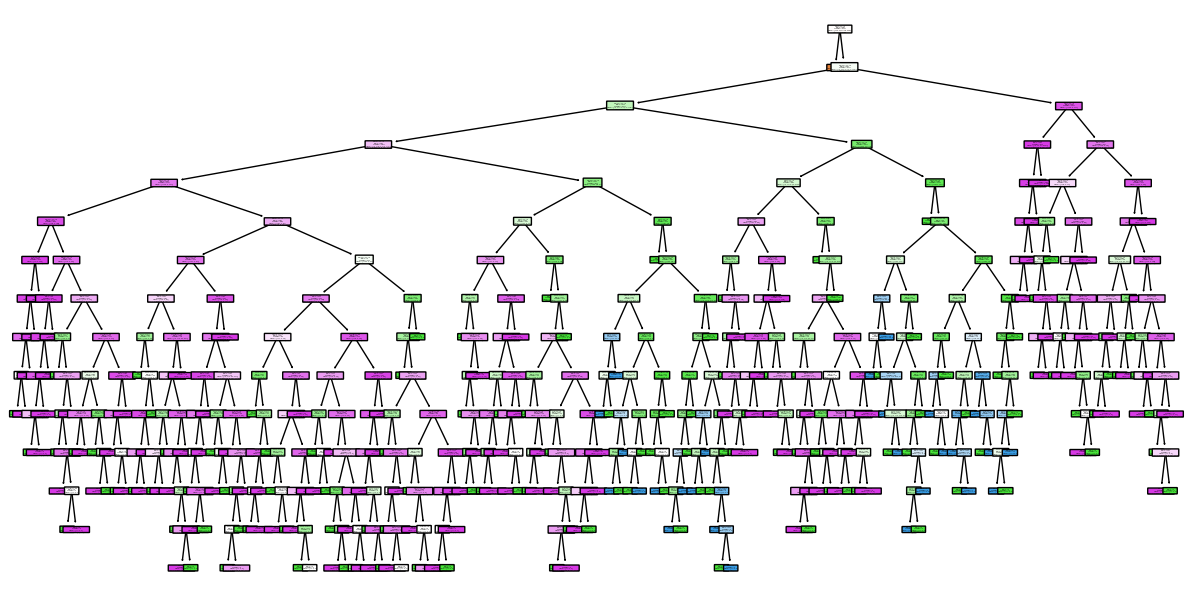

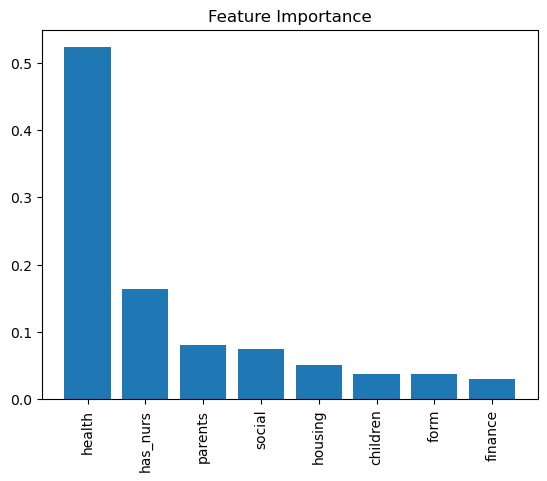

In [556]:
# Plot decision tree

feature_names = X_train_numeric.columns.tolist()
class_names = y_train.unique().tolist()

fig, ax = plt.subplots(figsize=(15, 7.5))
tree.plot_tree(model_decision_tree, filled=True, rounded=True, feature_names=feature_names, class_names=class_names, ax=ax)
plt.show()

importances = model_decision_tree.feature_importances_

indices = np.argsort(importances)[::-1]

names = [feature_names[i] for i in indices]

plt.figure()
plt.title("Feature Importance")
plt.bar(range(X_train_numeric.shape[1]), importances[indices])
plt.xticks(range(X_train_numeric.shape[1]), names, rotation=90)
plt.show()

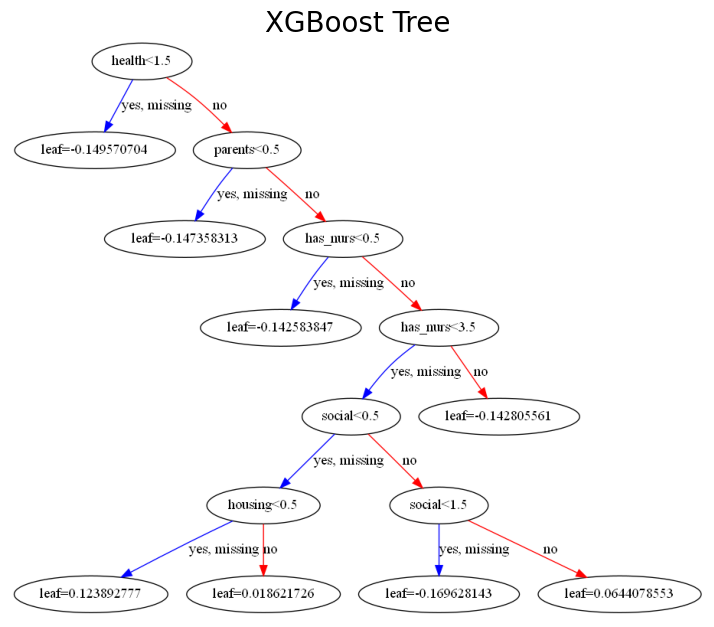

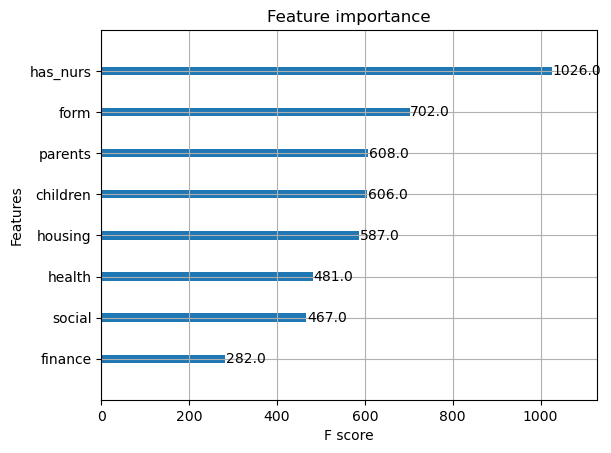

Number of trees: 200
Sizes of trees: [3, 47, 25, 41, 3, 49, 25, 43, 3, 49, 15, 43, 3, 51, 15, 43, 3, 55, 15, 47, 3, 57, 15, 43, 3, 57, 15, 43, 3, 55, 15, 65, 3, 57, 15, 65, 3, 61, 21, 65, 3, 57, 15, 63, 3, 63, 21, 61, 3, 65, 21, 63, 3, 59, 25, 55, 3, 65, 15, 63, 3, 59, 15, 89, 3, 59, 33, 101, 3, 63, 35, 97, 3, 63, 25, 115, 3, 59, 19, 101, 3, 61, 31, 107, 3, 107, 19, 101, 3, 61, 29, 107, 3, 109, 21, 113, 3, 109, 19, 111, 3, 101, 19, 109, 3, 109, 19, 111, 3, 97, 31, 93, 3, 113, 19, 113, 3, 87, 47, 103, 3, 101, 33, 97, 3, 107, 41, 107, 3, 93, 29, 113, 3, 99, 27, 103, 3, 87, 31, 105, 3, 91, 29, 89, 3, 101, 31, 105, 3, 95, 27, 83, 3, 105, 63, 103, 3, 83, 39, 101, 3, 87, 31, 87, 3, 109, 59, 101, 3, 79, 27, 93, 3, 97, 29, 73, 3, 85, 55, 95, 3, 77, 41, 81, 3, 83, 39, 95, 3, 81, 33, 87, 3, 77, 33, 91, 3, 77, 47, 69]


In [557]:
import xgboost as xgb

fig, ax = plt.subplots(figsize=(15, 7.5))
xgb.plot_tree(model, num_trees=62, ax=ax)
ax.set_title('XGBoost Tree', fontsize=20)
plt.show()

xgb.plot_importance(model)
plt.show()

num_trees = len(model.get_booster().get_dump())
print(f'Number of trees: {num_trees}')

trees = model.get_booster().get_dump()
tree_sizes = [tree.count('\n') for tree in trees]
print(f'Sizes of trees: {tree_sizes}')

# from sklearn.tree import export_graphviz

# export_graphviz(clf, out_file='tree.dot', 
#                 feature_names=feature_names,  # replace with your real feature names
#                 class_names=class_names,  # replace with your real class names
#                 filled=True)

# # Convert to PNG using system command (requires Graphviz)
# !dot -Tpng tree.dot -o tree.png